In [4]:
import itertools
import math
import pickle

In [118]:
def encode_squarefree(n):
    """
    input number of vertices n, generate the SAT encoding for squarefree graph
    return a list of tuple, where each tuple is a clause, and each integer is a variable (see Sage SAT documentation)
    """
    constraint = []
    edge_dict = {}
    counter = 1
    vertices_lst = list(range(1, n+1))
    edge_lst = list(itertools.combinations(vertices_lst, 2))
    all_comb = list(itertools.combinations(vertices_lst, 4))
    """
    edge_lst contains all possible edges expressed by v1,v2
    all_comb represents all possible combination of 4 vertices that makes a square
    """
    for edge in edge_lst:
        edge_dict[edge] = counter
        counter += 1
    """
    assign each edge to a number in dictionary form, so that we know which edge each integer is referring to
    """
    for square in all_comb:
        all_edges = list(itertools.combinations(square, 2))
        constraint_1 = tuple([-edge_dict[all_edges[0]],-edge_dict[all_edges[2]], -edge_dict[all_edges[3]], -edge_dict[all_edges[5]]])
        constraint_2 = tuple([-edge_dict[all_edges[1]],-edge_dict[all_edges[2]], -edge_dict[all_edges[3]], -edge_dict[all_edges[4]]])
        constraint_3 = tuple([-edge_dict[all_edges[0]],-edge_dict[all_edges[1]], -edge_dict[all_edges[4]], -edge_dict[all_edges[5]]])
        constraint = constraint + [constraint_1, constraint_2, constraint_3]
    """
    add the constraints of each square
    """
    return constraint

In [119]:
def encode_min_three(n):
    """
    input number of vertices n, generate the SAT encoding for minimum degree being 3
    return a list of tuple, where each tuple is a clause, and each integer is a variable (see Sage SAT documentation)
    """
    constraint = []
    edge_dict = {}
    counter = 1
    vertices_lst = list(range(1, n+1))
    edge_lst = list(itertools.combinations(vertices_lst, 2))
    extra_var_count = len(edge_lst)+1
    extra_var_dict = {}
    """
    created a list of all edges, all vertices, and a dictionary for extra variables
    """
    for edge in edge_lst:
        edge_dict[edge] = counter
        counter += 1
    """
    assign each edge to a number in dictionary form, so that we know which edge each integer is referring to
    """
    for vertex in vertices_lst:
        all_edges = [(vertex, i) for i in range(1, n+1) if vertex < i] + [(i, vertex) for i in range(1, n+1) if vertex > i]
        #Now we want at least three of these edges be true
        S_lst = [] #S represents the extra variables
        for i in range(len(all_edges)+1): #generate all possible s_k,n
            S_lst = S_lst + [(i, a) for a in range(0, 4)]
        for var in S_lst:
            extra_var_dict[(var, vertex)] = extra_var_count
            extra_var_count += 1 #similar to before, we label each integer with corresponding s_i,j
        for var in S_lst:
            i = var[0]  #implement base case
            j = var[1]
            if i == 0 or j == 0:
                continue
            constraint_1 = tuple([-extra_var_dict[((i-1,j),vertex)], extra_var_dict[((i,j),vertex)]])
            constraint_2 = tuple([-edge_dict[all_edges[i-1]], -extra_var_dict[((i-1,j-1),vertex)], extra_var_dict[((i,j),vertex)]])
            constraint_3 = tuple([-extra_var_dict[((i,j),vertex)], extra_var_dict[((i-1,j),vertex)], edge_dict[all_edges[i-1]]])
            constraint_4 = tuple([-extra_var_dict[((i,j),vertex)], extra_var_dict[((i-1,j),vertex)], extra_var_dict[((i-1,j-1),vertex)]])
            constraint = constraint + [constraint_1, constraint_2, constraint_3, constraint_4] 
    for c in extra_var_dict:
        if c[0] == (0,0):
            constraint = constraint + [tuple([extra_var_dict[c]])]
        elif c[0][0] < c[0][1]:
            constraint = constraint + [tuple([-extra_var_dict[c]])]
        elif c[0] == (n-1, 3):
            constraint = constraint + [tuple([extra_var_dict[c]])]
        elif c[0][0] == 0:
            constraint = constraint + [tuple([-extra_var_dict[c]])]
        elif c[0][1] == 0:#assign all at least 0 of the j variable to be true
            constraint = constraint + [tuple([extra_var_dict[c]])]
    """
    some variables need to be assigned true by default, see problem 7 of https://arxiv.org/pdf/1906.06251.pdf
    """
    return constraint

In [120]:
def all_triangle(n): #can confirm the encoding is correct
    """
    generate encoding for "all vertices are part of a triangle"
    we will use the same dictionary for all constraint for consistency and labeling purposes
    """
    constraint = []
    edge_dict = {}
    counter = 1
    vertices_lst = list(range(1, n+1))
    edge_lst = list(itertools.combinations(vertices_lst, 2))
    extra_var_count = len(edge_lst)+1
    extra_var_dict = {}
    for edge in edge_lst:
        edge_dict[edge] = counter
        counter += 1
    #edge_dict is the dictionary of all edges with labels, same as before, in the form of {(a,b): 1, ...}
    for vertex in vertices_lst:
        all_possible_triangles = []
        all_edges = [(vertex, i) for i in range(1, n+1) if vertex < i] + [(i, vertex) for i in range(1, n+1) if vertex > i]
        for two_edges in list(itertools.combinations(all_edges, 2)): #we produced all possible triangles adjacent to a specific vertex
            e1 = two_edges[0]
            e2 = two_edges[1]
            e3 = tuple(set(e1) - set(e2)) + tuple(set(e2) - set(e1))
            if e3[0] > e3[1]:
                e3 = (e3[1],e3[0])
            z = (e1, e2, e3, vertex)
            extra_var_dict[z] = extra_var_count
            extra_var_count += 1
            all_possible_triangles.append(extra_var_dict[z])
            constraint_1 = tuple([edge_dict[e1], -extra_var_dict[z]])
            constraint_2 = tuple([edge_dict[e2], -extra_var_dict[z]])
            constraint_3 = tuple([edge_dict[e3], -extra_var_dict[z]]) 
            constraint = constraint + [constraint_1, constraint_2, constraint_3]
        constraint = constraint + [tuple(all_possible_triangles)]
    return constraint

In [121]:
def gen_matrix(size):
    """
    given size of the square matrix, it generates matrix with entry from 1 to size^2 in order
    """
    matrix_lst = []
    new_lst=[]
    vertices = list(range(1, size^2+1))
    for i in range(size^2):
        if (i%size == 0 and i!=0):
            matrix_lst.append(new_lst)
            new_lst=[]
        new_lst.append(vertices[i])
    matrix_lst.append(new_lst)
    m = sage.matrix.constructor.Matrix(matrix_lst)
    return m

In [7]:
def upper_triangle(matrix):
    """
    put the entries of the upper trianglular matrix  into a list
    """
    entry_lst = []
    dim = matrix.dimensions()[0]
    for i in range(dim):
        for j in range(dim):
            if i < j:
                entry_lst.append(matrix[i][j])
    return entry_lst

In [8]:
def lower_triangle(matrix):
    """
    put the entries of the lower trianglular matrix  into a list
    """
    entry_lst = []
    dim = matrix.dimensions()[0]
    for j in range(dim):
        for i in range(dim):
            if i > j:
                entry_lst.append(matrix[i][j])
    return entry_lst

In [9]:
def relabel(constraint, num_of_edges, max_label, relabeled_dict): #relabeled = a dict with vertices that we've relabeled
    """
    relabel from all_triangle's variable dictionary to the regular label,
    this is needed as we might have overlapping extra variables in two constraints' dictionary,
    and we want to separate them.
    """
    new_constraint = ()
    for label in constraint:
        if abs(label) in relabeled_dict:
            if label > 0:
                new_constraint = new_constraint + (relabeled_dict[abs(label)],) #append the old label
            else:
                new_constraint = new_constraint + (-relabeled_dict[abs(label)],) #append the old label
        elif abs(label) > num_of_edges:
            #relabel
            if label > 0:
                new_constraint = new_constraint + (max_label + 1, )
                relabeled_dict[abs(label)] = max_label + 1
            else:
                new_constraint = new_constraint + (-(max_label + 1),)
                relabeled_dict[abs(label)] = max_label + 1
            max_label += 1
        else: #it is an edge label
            new_constraint = new_constraint + (label,)
    return [new_constraint, max_label, relabeled_dict]

In [10]:
def relabel_2(constraint, num_of_vertices, max_label, relabeled_dict_2):
    """
    relabel from block_iso's dictionary to the regular label
    """
    entry_to_edge_dict = {}
    new_constraint = ()
    adjacency_matrix = gen_matrix(num_of_vertices)
    """extract upper triangle"""
    """we can first get rif of the repetitive entries due to symmetry"""
    upper_matrix = upper_triangle(adjacency_matrix)
    lower_matrix = lower_triangle(adjacency_matrix)
    for i in range(1, len(upper_matrix)+1):
        entry_to_edge_dict[upper_matrix[i-1]] = i
    for var in constraint:
        if abs(var) in lower_matrix: 
            if var > 0:
                new_constraint = new_constraint + (upper_matrix[lower_matrix.index(var)],)
            else:
                new_constraint = new_constraint + (-upper_matrix[lower_matrix.index(abs(var))],)
        elif abs(var) in upper_matrix:
            new_constraint = new_constraint + (var,)
        elif abs(var) not in upper_matrix and abs(var) not in lower_matrix: #identify extra variables
            if abs(var) in relabeled_dict_2:
                if var > 0:
                    new_constraint = new_constraint + (relabeled_dict_2[abs(var)],)
                else:
                    new_constraint = new_constraint + (-relabeled_dict_2[abs(var)],)
            else:
                if var > 0:
                    new_constraint = new_constraint + (max_label + 1,)
                    relabeled_dict_2[abs(var)] = max_label + 1
                else:
                    new_constraint = new_constraint + (-(max_label + 1),)
                    relabeled_dict_2[abs(var)] = max_label + 1
            max_label += 1
        else:
            print ("entered with" + str(var))
            new_constraint = new_constraint + (var,)
    #relabel upper matrix with appropriate edges
    relabeled_constraint = ()
    for var in new_constraint:
        if abs(var) in upper_matrix:
            if var > 0:
                relabeled_constraint = relabeled_constraint + (entry_to_edge_dict[abs(var)],)
            else:
                relabeled_constraint = relabeled_constraint + (-entry_to_edge_dict[abs(var)],)
        else:
            relabeled_constraint = relabeled_constraint + (var,)
    return [relabeled_constraint, max_label, relabeled_dict_2]

In [44]:
def convert_maple_to_edge(g):
    #convert maplesat output to edge_lst
    g = g.split()
    edge_lst = list(itertools.combinations(range(1, 18), 2))
    actual_edges = []
    for i in range(1,len(g)-2):
        indicator = int(g[i])
        if indicator > 0:
            actual_edges.append(edge_lst[i])
    return actual_edges

In [45]:
def get_distinct(edge_lst):
    """
    same function but from a list of edges
    """
    distinct_edge_lst = []
    label_lst = []
    #count = 0
    for edges in edge_lst:
        g = Graph(edges)
        canonical = g.canonical_label(algorithm='sage').adjacency_matrix()
        if canonical in label_lst:
            continue
        label_lst.append(canonical)
        distinct_edge_lst.append(edges)
    #print (len(label_lst))
    #print ("total: "+str(count))
    print ("number of distinct graphs is " + str(len(distinct_edge_lst)))
    return distinct_edge_lst

In [46]:
def colorable(edge_lst):
    """
    given a list of edges, return a valid coloring if possible
    we can move this function to PySAT to change the SAT solver we are using.
    """
    solver = SAT()
    for edge in edge_lst:
        solver.add_clause(tuple([-edge[0],-edge[1]])) #no two adjacent vertices can be both 1
    vertices_lst = list(range(1, (max(max(edge_lst,key=lambda item:item[1])))+1))
    potential_triangles = list(itertools.combinations(vertices_lst, 3))
    for triangle in potential_triangles:
        v1 = triangle[0]
        v2 = triangle[1]
        v3 = triangle[2]
        if ((v1, v2) in edge_lst or (v2,v1) in edge_lst) and ((v2, v3) in edge_lst or (v3, v2) in edge_lst) and ((v1, v3) in edge_lst or (v3,v1) in edge_lst):
            solver.add_clause((v1,v2,v3))
            solver.add_clause((-v1, -v2))
            solver.add_clause((-v2, -v3))
            solver.add_clause((-v1, -v3))
        """
        if the triangle exists in this particular graph, it must satisfy 010 coloring
        """
    return solver()

In [ ]:
file1 = open('16_colorable.exhaust', 'r')
all_edge_lst = []
max_1 = 0
for line in file1:
    edge_lst = convert_maple_to_edge(line)
    #all_edge_lst.append(edge_lst)
#distinct_edge_lst = get_distinct(all_edge_lst)
#for g_edge in distinct_edge_lst:
    coloring = (colorable(edge_lst))
    if coloring != False:
        if coloring.count(True) > max_1:
            print (coloring.count(True))
            max_1 = coloring.count(True)

4
5


In [12]:
def block_iso(n):
    """Take in a "undetermined" graph representation given by Boolean edge variables? 
       Generate all possible $A_{i,j}$ and $A_{j,i}$, for instance, A_{i,j} are made by accessing the ith row, then take away the ith and jth entry.
       Put entries of $A_{i,j}$ as [x_1,x_2,...x_n], and entries of $A_{j,i}$ as [y_1,y_2,...,x_m]
       Use the lex clause from Lam's problem to generate clauses return all clauses"""
    adj_matrix = gen_matrix(n) #generate matrices with entry 1,2,...,
    adj_matrix_lst = list(itertools.chain(*list(adj_matrix)))
    dict = {}
    size = n
    count = 1
    constraint = []
    extra_var_count = n^2+1
    for entry in adj_matrix_lst:
        dict[entry] = count
        count += 1
    for i in range(n-1):
        for j in range(i+1, size):
            A_i = list(adj_matrix[i])
            A_j = list(adj_matrix[j])
            A_ij = A_i[:i] + A_i[i+1:j] + A_i[j+1:]
            A_ji = A_j[:i] + A_j[ i+1:j] + A_j[j+1:]
            #print (A_ij, A_ji)
            for n in range(len(A_ij)):
                dict[(i,j,n)] = extra_var_count
                extra_var_count += 1
            for n in range(len(A_ij)):
                if n == 0:
                    constraint_1 = tuple([-dict[A_ij[n]], dict[A_ji[n]]])
                    constraint_2 = tuple([-dict[A_ij[n]], dict[(i,j,n)]])
                    constraint_3 = tuple([dict[A_ji[n]], dict[(i,j,n)]])
                    constraint = constraint + [constraint_1, constraint_2, constraint_3]
                else:
                    constraint_1 = tuple([-dict[A_ij[n]], dict[A_ji[n]], -dict[(i,j,n)]])
                    constraint_2 = tuple([-dict[A_ij[n]], dict[(i,j,n)], -dict[(i,j,n-1)]])
                    constraint_3 = tuple([dict[A_ji[n]], dict[(i,j,n)], -dict[(i,j,n-1)]])
                    constraint = constraint + [constraint_1, constraint_2, constraint_3]
            constraint_4 = tuple([-dict[A_ij[-1]], dict[A_ji[-1]], -dict[(i,j,len(A_ij)-1)]])
            constraint = constraint + [constraint_4]
    for i in range(size):
        constraint = constraint + [tuple([-dict[adj_matrix[i][i]]])]
        for j in range(size):
            constraint = constraint + [tuple([-dict[adj_matrix[i][j]], dict[adj_matrix[j][i]]])]#make sure it's symmetric
            constraint = constraint + [tuple([dict[adj_matrix[i][j]], -dict[adj_matrix[j][i]]])]
    #print (dict)
    return constraint

In [13]:
def generate_graph(n, added_constraint, candidate_count):
    """
    n be greater and equal to 3
    """
    """
    Given n vertices, we can generate graph that satisfies all 4 constraints while blocking the isomorphism
    Please ignore these commented print statement, I was using them to check for the correctness of the program
    """
    solver = SAT()
    num_of_edges = factorial(n)/(factorial(2)*factorial(n-2))
    relabeled_dict = {} #list of relabeled vertices
    relabeled_dict_2 = {}
    #print (num_of_edges)
    max_label = (n^2)*4 + num_of_edges
    #print (max_label)
    for constraint in encode_min_three(n): #each vertex has minimum degree 3, contain extrvariables
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in encode_squarefree(n): #does not contain C4 subgraph, no extra variables
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in added_constraint: #make sure it keeps generating different graphs, no extra variables
        #print ("added")
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in all_triangle(n): #every vertex is a part of the triangle, needs relabeling
        #print ("triangle")
        """print ("old: " + str(max_label))
        print (constraint)"""
        relabelled = relabel(constraint, num_of_edges, max_label, relabeled_dict)
        constraint = relabelled[0]
        #print (constraint)
        max_label = relabelled[1]
        #print ("new: " + str(max_label))
        relabeled_dict = relabelled[2]
        solver.add_clause(constraint) #problem solved here is double-labeled free variables"""
    #print (relabeled_dict)
    for constraint in block_iso(n): #block some isomorphic graphs
        """print ("iso")
        print ("old: " + str(max_label))
        print (constraint)"""
        relabelled = relabel_2(constraint, n, max_label, relabeled_dict_2)
        constraint = relabelled[0]
        max_label = relabelled[1]
        #print (constraint)
        """print ("new: " + str(max_label))"""
        relabeled_dict_2 = relabelled[2]
        solver.add_clause(constraint)
    result = solver()
    if result == False:
        print ("Candidate Count: " + str(candidate_count))
        return False
    else:
        true_edge = result[1:num_of_edges+1]
        vertices_lst = list(range(1, n+1))
        edge_lst = list(itertools.combinations(vertices_lst, 2))
        true_edge_lst = []
        for i in range(len(edge_lst)):
            edge = edge_lst[i]
            if true_edge[i] == True:
                true_edge_lst.append(edge)
        #if colorable(true_edge_lst) == False: #check that the graph is not 101 colorable
        candidate_count += 1
        if candidate_count %100 == 0:
            print (candidate_count)
        g = Graph(true_edge_lst)
        g.plot().show()
        #print (g.degree_sequence())
        #print (g.adjacency_matrix())
        #print ('---------------------------------')
        """
        we can produce relavant information of the generated graph if we like
        """
        indicator = 0
        ind_lst = []
        for i in range(len(edge_lst)): #len(edge_lst)
            if result[1:][i] == True:
                indicator = -(i+1)
            else:
                indicator = i+1
            ind_lst.append(indicator)
        added_constraint.append(tuple(ind_lst))
        """
        add the generated graph as a new constraint, so that the SAT solver produce a new graph
        """
        return generate_graph(n, added_constraint, candidate_count)

In [14]:
generate_graph(10, [], 0)

KeyboardInterrupt: 

In [13]:
from sage.sat.solvers.dimacs import DIMACS
def generate_dimacs(n, added_constraint):
    """
    very similar to generate_graph, but only save the constraint into a DIMACS file
    """
    candidate_count = 0
    fn = tmp_filename('all_constraints_' + str(n))
    solver = DIMACS()
    num_of_edges = factorial(n)/(factorial(2)*factorial(n-2))
    relabeled_dict = {} #list of relabeled vertices
    relabeled_dict_2 = {}
    #print (num_of_edges)
    max_label = (n^2)*4 + num_of_edges
    #print (max_label)
    for constraint in encode_min_three(n): #each vertex has minimum degree 3, contain extrvariables
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in encode_squarefree(n): #does not contain C4 subgraph, no extra variables
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in added_constraint: #make sure it keeps generating different graphs, no extra variables
        #print ("added")
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in all_triangle(n): #every vertex is a part of the triangle, needs relabeling
        #print ("triangle")
        #print (max_label)
        #print (constraint)
        relabelled = relabel(constraint, num_of_edges, max_label, relabeled_dict)
        constraint = relabelled[0]
        #print (constraint)
        max_label = relabelled[1]
        relabeled_dict = relabelled[2]
        solver.add_clause(constraint) #problem solved here is double-labeled free variables"""
    for constraint in block_iso(n): #block some isomorphic graphs
        #print (max_label)
        #print (constraint)
        relabelled = relabel_2(constraint, n, max_label, relabeled_dict_2)
        constraint = relabelled[0]
        max_label = relabelled[1]
        #print (constraint)
        relabeled_dict_2 = relabelled[2]
        solver.add_clause(constraint)
    _ = solver.write(fn)

In [14]:
from sage.sat.solvers.dimacs import DIMACS
def generate_dimacs_1(n, added_constraint):
    """
    similar to generate_dimacs, but only for constraint 1
    """
    candidate_count = 0
    fn = tmp_filename('all_constraints_22_c1')
    solver = DIMACS()
    num_of_edges = factorial(n)/(factorial(2)*factorial(n-2))
    relabeled_dict = {} #list of relabeled vertices
    relabeled_dict_2 = {}
    #print (num_of_edges)
    max_label = (n^2)*4 + num_of_edges
    #print (max_label)
    for constraint in encode_min_three(n): #each vertex has minimum degree 3, contain extrvariables
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in added_constraint: #make sure it keeps generating different graphs, no extra variables
        #print ("added")
        #print (constraint)
        solver.add_clause(constraint)
    _ = solver.write(fn)

In [15]:
from sage.sat.solvers.dimacs import DIMACS
def generate_dimacs_2(n, added_constraint):
    """
    similar to generate_dimacs, but only for constraint 2
    """
    candidate_count = 0
    fn = tmp_filename('all_constraints_22_c2')
    solver = DIMACS()
    num_of_edges = factorial(n)/(factorial(2)*factorial(n-2))
    relabeled_dict = {} #list of relabeled vertices
    relabeled_dict_2 = {}
    #print (num_of_edges)
    max_label = (n^2)*4 + num_of_edges
    #print (max_label)
    for constraint in encode_squarefree(n): #does not contain C4 subgraph, no extra variables
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in added_constraint: #make sure it keeps generating different graphs, no extra variables
        #print ("added")
        #print (constraint)
        solver.add_clause(constraint)
    _ = solver.write(fn)

In [16]:
from sage.sat.solvers.dimacs import DIMACS
def generate_dimacs_3(n, added_constraint):
    """
    similar to generate_dimacs, but only for constraint 3
    """
    candidate_count = 0
    fn = tmp_filename('all_constraints_22_c3')
    solver = DIMACS()
    num_of_edges = factorial(n)/(factorial(2)*factorial(n-2))
    relabeled_dict = {} #list of relabeled vertices
    relabeled_dict_2 = {}
    #print (num_of_edges)
    max_label = (n^2)*4 + num_of_edges
    #print (max_label)
    for constraint in added_constraint: #make sure it keeps generating different graphs, no extra variables
        #print ("added")
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in all_triangle(n): #every vertex is a part of the triangle, needs relabeling
        #print ("triangle")
        #print (max_label)
        #print (constraint)
        solver.add_clause(constraint) #problem solved here is double-labeled free variables"""
    _ = solver.write(fn)

In [17]:
from sage.sat.solvers.dimacs import DIMACS
def generate_dimacs_4(n, added_constraint):
    """
    similar to generate_dimacs, but only for constraint 4
    """
    candidate_count = 0
    fn = tmp_filename('all_constraints_22_c4')
    solver = DIMACS()
    num_of_edges = factorial(n)/(factorial(2)*factorial(n-2))
    relabeled_dict = {} #list of relabeled vertices
    relabeled_dict_2 = {}
    #print (num_of_edges)
    max_label = 1
    #print (max_label)
    for constraint in added_constraint: #make sure it keeps generating different graphs, no extra variables
        #print ("added")
        #print (constraint)
        solver.add_clause(constraint)
    for constraint in block_iso(n): #block some isomorphic graphs
        #print (max_label)
        #print (constraint)
        relabelled = relabel_2(constraint, n, max_label, relabeled_dict_2)
        constraint = relabelled[0]
        max_label = relabelled[1]
        #print (constraint)
        relabeled_dict_2 = relabelled[2]
        solver.add_clause(constraint)
    _ = solver.write(fn)

In [18]:
import ast
def check_iso(file):
    """
    take in an file with many graphs in the form of lists of edges, check the number of isomorphic graphs by inspecting all possible pairs
    """
    total_count = 0
    count = 0
    iso_count = 0
    graph_lst = []
    iso_lst = []
    file1 = open(file, 'r')
    lines = file1.readlines()
    for line in lines:
        total_count += 1
        edges = ast.literal_eval(line)
        g = Graph(edges)
        #print (g.degree_sequence())
        graph_lst.append(g)
    """for pair in itertools.combinations(graph_lst, 2):
        graph_1 = pair[0]
        graph_2 = pair[1]
        if graph_1.is_isomorphic(graph_2):
            iso_lst.append(pair)
            iso_count += 1"""
    print (total_count)
    print (iso_count)

In [7]:
def get_distinct(file):
    """
    take in an file with many graphs in the form of lists of edges, check the number of isomorphic graphs by inspecting all possible pairs
    """
    label_lst = []
    all_graph = []
    #count = 0
    with (open(file, "rb")) as openfile:
        while True:
            try:
                edges = pickle.load(openfile)
                print (edges)
                all_graph.append(edges)
                g = Graph(edges)
                #coutn += 1
                canonical = g.canonical_label(algorithm='sage').adjacency_matrix()
                if canonical in label_lst:
                    continue
                label_lst.append(canonical)
            except EOFError:
                break
    #print (len(label_lst))
    #print ("total: "+str(count))
    print (len(all_graph))
    return label_lst

In [11]:
def get_distinct(edge_lst):
    """
    same function but from a list of edges
    """
    label_lst = []
    all_graph = []
    #count = 0
    for edges in edge_lst:
        all_graph.append(edges)
        g = Graph(edges)
        canonical = g.canonical_label(algorithm='sage').adjacency_matrix()
        if canonical in label_lst:
            continue
        label_lst.append(canonical)
    print (len(label_lst))
    #print ("total: "+str(count))
    print (len(all_graph))
    return label_lst

In [123]:
distinct_g = get_distinct(all_graphs)

8
57368


In [130]:
candidates = ['R??CA?_E?g@_o_kCHI?TG`PORGRHS?', 'R??CA?_E?g@_o_kCHI?eO`PPCi@TG_', 'R??CA?_c?WPAPADOGWDKAAXOYGb`c?', 'R??CA?_c?o@_o_POEI?UH`L?UHBPS?', 'R??CA?_c?oH_OoHOA`KKGaSOIiB`g?', 'R??CA?_c?oH_OoHOA`KKGaSPOs@TS?', 'R??CAA_S@O@_c_@oCcGggAeOpIERG?', 'R??CB@OKCO@_POCgHDDE?@`OgSCgs?']
for graph in distinct_g:
    g = Graph(graph)
    for candidate in candidates:
        can_g = Graph(candidate, sparse=True)
        if g.is_isomorphic(can_g):
            print (candidate)

R??CA?_c?oH_OoHOA`KKGaSPOs@TS?
R??CA?_c?oH_OoHOA`KKGaSOIiB`g?
R??CA?_c?WPAPADOGWDKAAXOYGb`c?
R??CA?_c?o@_o_POEI?UH`L?UHBPS?
R??CA?_E?g@_o_kCHI?TG`PORGRHS?
R??CA?_E?g@_o_kCHI?eO`PPCi@TG_
R??CAA_S@O@_c_@oCcGggAeOpIERG?
R??CB@OKCO@_POCgHDDE?@`OgSCgs?


In [13]:
def find_triangle(edge_lst):
    """given a edge_lst, return a arbitrary triangle that exists in the form of (v_1,v_2,v_3)"""
    n = len(set([item for sublist in edge_lst for item in sublist]))
    vertices_lst = list(range(0, n)) #we will assume the edge_lst starts with vertex "0" instead of "1"
    all_triangles = itertools.combinations(vertices_lst, 3)
    for triangle in all_triangles:
        e_1 = (triangle[0], triangle[1])
        e_2 = (triangle[0], triangle[2])
        e_3 = (triangle[1], triangle[2])
        if (e_1 in edge_lst or Reverse(e_1) in edge_lst) and (e_2 in edge_lst or Reverse(e_2) in edge_lst) and (e_3 in edge_lst or Reverse(e_3) in edge_lst):
            return triangle
    return False

In [23]:
def find_triangle(edge_lst):
    """given a edge_lst, return a arbitrary triangle that exists in the form of (v_1,v_2,v_3)"""
    n = len(set([item for sublist in edge_lst for item in sublist]))
    vertices_lst = list(range(0, n)) #we will assume the edge_lst starts with vertex "0" instead of "1"
    all_triangles = itertools.combinations(vertices_lst, 3)
    for triangle in all_triangles:
        e_1 = (triangle[0], triangle[1])
        e_2 = (triangle[0], triangle[2])
        e_3 = (triangle[1], triangle[2])
        if (e_1 in edge_lst or Reverse(e_1) in edge_lst) and (e_2 in edge_lst or Reverse(e_2) in edge_lst) and (e_3 in edge_lst or Reverse(e_3) in edge_lst):
            return triangle
    return False

def Reverse(tuples):
    new_tup = tuples[::-1]
    return new_tup

In [101]:
def check_all_triangle(graph, edge_lst):
    vertices_lst = list(graph.vertices())
    for vertex in vertices_lst:
        adjacent_lst = graph.neighbors(vertex)
        all_possible = list(itertools.combinations(adjacent_lst, 2))
        for comb in all_possible:
            if comb in edge_lst or Reverse(comb) in edge_lst:
                print (str(vertex) + ' is good.')

In [102]:
def g6_triangle(g6):
    G = Graph(g6, sparse=True)
    edge_lst = [tuple(ele for ele in sub if ele != None) for sub in list(G.edges())] 
    check_all_triangle(G, edge_lst)

In [122]:
g6_triangle("R??CB@OKCO@_POCgHDDE?@`OgSCgs?")

0 is good.
0 is good.
1 is good.
1 is good.
2 is good.
2 is good.
3 is good.
3 is good.
4 is good.
4 is good.
5 is good.
5 is good.
6 is good.
6 is good.
7 is good.
7 is good.
8 is good.
8 is good.
9 is good.
9 is good.
10 is good.
10 is good.
11 is good.
11 is good.
12 is good.
12 is good.
13 is good.
13 is good.
14 is good.
14 is good.
15 is good.
15 is good.
16 is good.
16 is good.
17 is good.
17 is good.
18 is good.
18 is good.
18 is good.


In [44]:
from collections import Counter
from itertools import chain

def check_squarefree(graph):
    vertices_lst = list(graph.vertices())
    possible_c4 = list(itertools.combinations(vertices_lst, 4))
    for c4 in possible_c4:
        edge_lst = graph.subgraph(list(c4)).edges()
        if len(edge_lst) >= 4:
            res = Counter(chain(*edge_lst))
            del res[None]
            value_lst = []
            for value in res.values():
                value_lst.append(value)
            if value_lst == [2,2,2,2]:
                print ("exists")
                print (edge_lst)

In [49]:
g = [(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 9), (3, 10), (3, 13), (3, 16), (4, 7), (4, 8), (4, 13), (4, 15), (5, 6), (5, 8), (5, 10), (5, 12), (6, 7), (6, 12), (6, 14), (7, 9), (7, 11), (7, 14), (8, 10), (8, 15), (9, 10), (9, 11), (11, 17), (12, 13), (13, 16), (14, 16), (15, 17)]
colorable(g)

False

In [27]:
g.neighbors(12)

[6, 2, 13, 5]

In [9]:
get_distinct(r"script/candidates_17v")

[(1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (2, 10), (2, 11), (2, 12), (2, 17), (3, 8), (3, 9), (3, 12), (3, 16), (4, 7), (4, 9), (4, 11), (4, 15), (5, 6), (5, 8), (5, 10), (5, 14), (6, 7), (6, 10), (6, 13), (7, 9), (7, 13), (8, 12), (8, 14), (9, 16), (10, 11), (10, 16), (11, 15), (12, 17), (13, 17), (14, 15)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 10), (2, 11), (2, 12), (2, 13), (3, 7), (3, 8), (3, 9), (3, 13), (4, 6), (4, 9), (4, 12), (4, 17), (5, 6), (5, 8), (5, 11), (5, 16), (6, 7), (6, 11), (6, 15), (7, 13), (7, 15), (8, 9), (8, 16), (9, 10), (9, 14), (10, 11), (10, 14), (12, 13), (12, 17), (14, 15), (16, 17)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 10), (2, 11), (2, 12), (2, 13), (3, 7), (3, 8), (3, 9), (3, 13), (4, 6), (4, 9), (4, 12), (4, 17), (5, 6), (5, 8), (5, 11), (5, 16), (6, 7), (6, 12), (6, 15), (7, 13), (7, 15), (8, 9), (8, 10), (8, 14), (9, 17), (10, 12), (10, 14), (11, 13), (11, 16), (14, 15), (16, 17)]
[(1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (2, 9), (2, 10

[
[0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0]
[1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
[0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0]
[1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
[0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
[1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0]
[0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0]
[0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1]
[0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0]
[0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0]
]


[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 9), (3, 10), (3, 13), (3, 16), (4, 8), (4, 10), (4, 12), (4, 15), (5, 6), (5, 7), (5, 12), (5, 16), (6, 7), (6, 9), (6, 14), (7, 8), (7, 11), (8, 11), (8, 15), (9, 10), (9, 14), (10, 12), (11, 13), (12, 17), (13, 16), (14, 17), (15, 16)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 8), (3, 9), (3, 10), (3, 17), (4, 7), (4, 10), (4, 13), (4, 16), (5, 6), (5, 9), (5, 12), (5, 15), (6, 7), (6, 8), (6, 12), (7, 8), (7, 16), (8, 11), (8, 14), (9, 10), (9, 15), (10, 13), (11, 13), (11, 14), (12, 17), (14, 15), (16, 17)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 8), (3, 9), (3, 10), (3, 13), (4, 7), (4, 10), (4, 12), (4, 16), (5, 6), (5, 9), (5, 12), (5, 15), (6, 7), (6, 8), (6, 11), (6, 14), (7, 10), (7, 11), (8, 13), (8, 14), (9, 10), (9, 15), (11, 17), (12, 13), (12, 16), (14, 16), (15, 17)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (

In [8]:
get_distinct(r"archive/candidates_17v")

[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 9), (3, 10), (3, 13), (3, 16), (4, 7), (4, 8), (4, 12), (4, 15), (5, 6), (5, 10), (5, 11), (5, 14), (6, 8), (6, 9), (6, 14), (7, 8), (7, 10), (7, 17), (8, 9), (9, 13), (10, 11), (10, 16), (11, 12), (12, 15), (13, 17), (14, 17), (15, 16)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 9), (3, 10), (3, 13), (3, 16), (4, 7), (4, 8), (4, 12), (4, 15), (5, 6), (5, 10), (5, 12), (5, 14), (6, 8), (6, 9), (6, 14), (7, 8), (7, 10), (7, 11), (8, 9), (9, 13), (10, 11), (10, 16), (11, 17), (12, 13), (12, 15), (14, 17), (15, 16)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 9), (3, 10), (3, 13), (3, 16), (4, 7), (4, 8), (4, 12), (4, 16), (5, 6), (5, 10), (5, 11), (5, 15), (6, 8), (6, 9), (6, 15), (7, 8), (7, 10), (7, 14), (8, 9), (9, 13), (10, 11), (10, 14), (11, 12), (12, 16), (13, 17), (14, 17), (15, 16)]
[(1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (2, 9), (

[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 8), (3, 9), (3, 10), (3, 16), (4, 7), (4, 10), (4, 13), (4, 15), (5, 6), (5, 9), (5, 12), (5, 14), (6, 7), (6, 8), (6, 11), (6, 14), (7, 8), (7, 13), (8, 16), (9, 10), (9, 12), (10, 11), (10, 15), (11, 17), (12, 13), (14, 15), (16, 17)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 8), (3, 9), (3, 10), (3, 16), (4, 7), (4, 10), (4, 13), (4, 15), (5, 6), (5, 9), (5, 12), (5, 14), (6, 7), (6, 8), (6, 14), (7, 8), (7, 13), (8, 11), (8, 16), (9, 10), (9, 12), (10, 15), (11, 12), (11, 15), (13, 17), (14, 15), (16, 17)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2, 13), (2, 17), (3, 8), (3, 9), (3, 10), (3, 13), (3, 16), (4, 7), (4, 10), (4, 12), (4, 15), (5, 6), (5, 9), (5, 11), (5, 14), (6, 7), (6, 8), (6, 14), (7, 8), (7, 12), (8, 13), (9, 10), (9, 11), (10, 15), (11, 12), (12, 16), (13, 17), (14, 16), (15, 17)]
[(1, 14), (1, 15), (1, 16), (1, 17), (2, 11), (2, 12), (2,

[
[0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0]
[1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
[0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0]
[1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
[0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
[1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0]
[0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0]
[0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1]
[0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0]
[0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0]
]

324


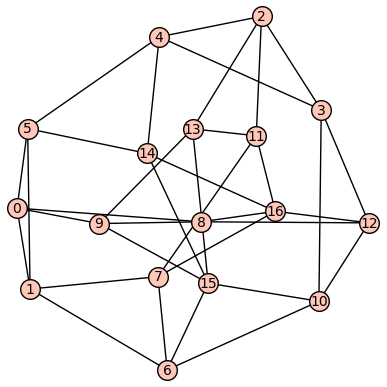

In [6]:
for g in get_distinct(r"archive/candidates_17v"):
    graph = Graph(g, format = 'adjacency_matrix')
    graph.show()
    edge_lst = list(graph.edges())
    relabel_edge_lst = []
    for edge in edge_lst:
        v_1 = edge[0] + 1
        v_2 = edge[1] + 1
        relabel_edge = (v_1, v_2)
        relabel_edge_lst.append(relabel_edge)

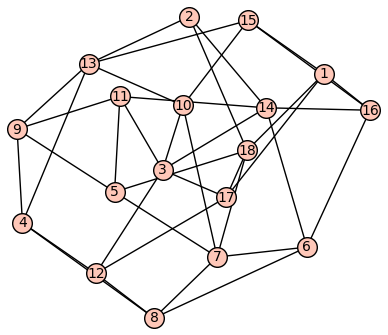

[5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]

In [129]:
graph.show() #this is the 17 vertices graph we generated
g_ref = Graph([(0,11),(0,5),(0,7),(0,13),(1,13),(1,6),(1,15),(1,8),(2,9),(2,10),(2,7),(2,15),(3,14),(3,8),(3,16),(3,10),(4,14),(4,12),(4,11),(4,9),(5,11),(5,16),(5,15),(6,12),(6,16),(6,13),(7,10),(7,13),(8,14),(8,15),(9,12),(9,15),(10,16),(11,14),(12,16)])
graph.is_isomorphic(g_ref)
graph.degree_sequence()

In [7]:
all_graphs = []
file1 = open('19_solution/19-unique-sols.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    g = line.split()
    edge_lst = list(itertools.combinations(range(1, 20), 2))
    actual_edges = []
    try:
        g.remove("a")
        g.remove("0")
    except:
        print (g)
    for i in range(len(g)):
        indicator = int(g[i])
        if indicator > 0:
            actual_edges.append(edge_lst[i])
    all_graphs.append(actual_edges)

In [39]:
len(all_graphs)

57368

In [13]:
g_1.neighbors(14)

[6, 16, 2, 3, 11]

In [7]:
g_1.degree_sequence()

[5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]

In [5]:
check_squarefree(g_1)

In [19]:
check_all_triangle(g_1)

1 is in a triangle
1 is in a triangle
1 is in a triangle
1 is in a triangle
1 is in a triangle
1 is in a triangle
2 is in a triangle
3 is in a triangle
3 is in a triangle
3 is in a triangle
4 is in a triangle
5 is in a triangle
5 is in a triangle
5 is in a triangle
6 is in a triangle
6 is in a triangle
6 is in a triangle
7 is in a triangle
7 is in a triangle
7 is in a triangle
8 is in a triangle
8 is in a triangle
8 is in a triangle
9 is in a triangle
9 is in a triangle
10 is in a triangle
10 is in a triangle
11 is in a triangle
11 is in a triangle
12 is in a triangle
12 is in a triangle
12 is in a triangle
13 is in a triangle
13 is in a triangle
13 is in a triangle
13 is in a triangle
14 is in a triangle
14 is in a triangle
14 is in a triangle
14 is in a triangle
14 is in a triangle
15 is in a triangle
15 is in a triangle
15 is in a triangle
16 is in a triangle
16 is in a triangle
16 is in a triangle
17 is in a triangle
17 is in a triangle
17 is in a triangle
17 is in a triangle
18 is

In [22]:
file1 = open('18.exhaust', 'r')
Lines = file1.readlines()
edge_lst = list(itertools.combinations(range(1, 19), 2))
edges_lst = []
for line in Lines:
    g = str(line)
    g = g.split()
    try:
        g.remove("a")
        g.remove("0")
    except:
        print (g)
    actual_edges = []
    for i in range(len(g)):
        indicator = int(g[i])
        if indicator > 0:
            actual_edges.append(edge_lst[i])
    edges_lst.append(actual_edges)

In [25]:
canonical_1 = get_distinct(edges_lst)[0]
canonical_2 = get_distinct(edges_lst)[1]
graph1 = Graph(canonical_1, format = 'adjacency_matrix')
graph2 = Graph(canonical_2, format = 'adjacency_matrix')

4319
4319


In [27]:
g_ref_1 = Graph([(0,6),(0,12),(0,11),(0,15),(1,13),(1,7),(1,11),(1,16),(2,12),(2,8),(2,17),(2,9),(3,14),(3,8),(3,10),(3,13),(4,9),(4,15),(4,10),(4,16),(5,12),(5,14),(5,16),(6,11),(6,17),(6,14),(7,13),(7,17),(7,15),(8,12),(8,13),(9,16),(9,17),(10,14),(10,15),(11,16),(12,15),(14,17)])

In [30]:
graph1.is_isomorphic(g_ref_1)

True

In [31]:
g_ref_2 = Graph([(0,8),(0,10),(0,6),(0,16),(1,12),(1,7),(1,13),(1,17),(2,8),(2,11),(2,17),(2,15),(3,10),(3,14),(3,9),(3,13),(4,9),(4,11),(4,16),(4,12),(5,14),(5,17),(5,16),(6,15),(6,16),(6,13),(7,14),(7,15),(7,12),(8,10),(8,17),(9,11),(9,13),(10,14),(11,15),(12,16),(13,17),(14,15)])

In [32]:
graph2.is_isomorphic(g_ref_2)

True

**Ignore codes below for now, might not be useful**

In [ ]:
"""this is not behaving properly"""
def block_iso(g):
    #we take in a graph in SageMath, then generate the blocking constraint for its isomorphic graphs
    #we will create a dictionary with (i, j): label
    matrix = g.adjacency_matrix()
    num_of_vertex = len(g.vertices())
    dict = {}
    count = 1
    extra_var = num_of_vertex^2+1
    constraint = []
    for i in range(num_of_vertex):
        for j in range(num_of_vertex):
            dict[(i,j)] = count
            count += 1
    for i in range(num_of_vertex):
        for j in range(num_of_vertex):
            constraint = constraint + [tuple([-dict[(i,j)], dict[(j,i)]])]#make sure it's symmetric
            constraint = constraint + [tuple([dict[(i,j)], -dict[(j,i)]])]
            constraint = constraint + [tuple([-dict[(i,i)]])]
    for i in range(num_of_vertex):
        for j in range(i+1, num_of_vertex):
            #checked, i and j are fine
            row_ij = list(matrix[i])
            row_ji = list(matrix[j])
            aij = row_ij[:i] + row_ij[i+1:j] + row_ij[j+1:]
            aji = row_ji[:i] + row_ji[i+1:j] + row_ji[j+1:]
            #row_ij and row_ji are fine
            for n in range(len(aij)-1):
                dict[(i,j,n)] = extra_var
                extra_var += 1
            for k in range(1, len(aij)-1):
                x = aij[k]
                y = aji[k]
                if k < i:
                    coordinate_x = (i, k)
                    coordinate_y = (j, k)
                elif k >= i and k < j-1:
                    coordinate_x = (i, k+1)
                    coordinate_y = (j, k+1)
                else:
                    coordinate_x = (i, k+2)
                    coordinate_y = (j, k+2)
                constraint_1 = tuple([-dict[coordinate_x], dict[coordinate_y], -dict[(i,j,k-1)]])
                constraint_2 = tuple([-dict[coordinate_x], dict[(i,j,k)], -dict[(i,j,k-1)]])
                constraint_3 = tuple([dict[coordinate_y], dict[(i,j,k)], -dict[(i,j,k-1)]])
                constraint = constraint + [constraint_1, constraint_2, constraint_3]
            constraint = constraint + [tuple([-dict[(i, len(aij)+1)], dict[(j, len(aij)+1)], -dict[(i,j,len(aij)-2)]])]
    constraint = constraint + [tuple(list(range(1, num_of_vertex^2+1)))]
    return constraint
            #debug
    #relabel?

In [ ]:
"""this is for testing"""
"""problem: the adjacency matrix is not symmetric, check the lex constraint, either that's incomplete or you are wrong"""
def generate_graph(g, added_constraint):
    matrix = 0
    solver = SAT()
    for c in block_iso(g):
        solver.add_clause(c)
        added_constraint.append(c)
    for c in added_constraint:
        solver.add_clause(c)
    if solver() == False:
        return False
    else:
        num_vertex = len(g.vertices())
        result = solver()
        vertices = result[1:num_vertex^2+1]
        for i in range(len(vertices)):
            if vertices[i] == False:
                vertices[i] = 0
            else:
                vertices[i] = 1
        matrix_lst = []
        new_lst=[]
        for i in range(num_vertex^2):
            if (i%num_vertex == 0 and i!=0):
                matrix_lst.append(new_lst)
                new_lst=[]
            new_lst.append(vertices[i])
        matrix_lst.append(new_lst)
        m = sage.matrix.constructor.Matrix(matrix_lst)
        graph = Graph(m, format = 'adjacency_matrix')
        graph.show()
        indicator = 0
        ind_lst = []
        for i in range(len(result[1:17])):
            if result[1:][i] == True:
                indicator = -(i+1)
            else:
                indicator = i+1
            ind_lst.append(indicator)
        added_constraint.append(tuple(ind_lst))
        return generate_graph(g, added_constraint)

In [60]:
def iso_test(n, added_constraint, count):
    matrix = 0
    solver = SAT()
    for c in block_iso(n):
        solver.add_clause(c)
        added_constraint.append(c)
    for c in added_constraint:
        solver.add_clause(c)
    if solver() == False:
        return False
    else:
        num_vertex = n
        result = solver()
        vertices = result[1:num_vertex^2+1]
        for i in range(len(vertices)):
            if vertices[i] == False:
                vertices[i] = 0
            else:
                vertices[i] = 1
        matrix_lst = []
        new_lst=[]
        for i in range(num_vertex^2):
            if (i%num_vertex == 0 and i!=0):
                matrix_lst.append(new_lst)
                new_lst=[]
            new_lst.append(vertices[i])
        matrix_lst.append(new_lst)
        m = sage.matrix.constructor.Matrix(matrix_lst)
        #print (m)
        graph = Graph(m, format = 'adjacency_matrix')
        count += 1
        #print (count)
        graph.show()
        indicator = 0
        ind_lst_1 = []
        ind_lst_2 = []
        for i in range(len(result[1:num_vertex^2+1])):
            if result[1:][i] == True:
                indicator = -(i+1)
            else:
                indicator = i+1
            ind_lst_1.append(indicator)
        #print (ind_lst_1)
        """for i in range(len(result)-1):
            if result[1:][i] == True:
                indicator = -(i+1)
            else:
                indicator = i+1
            ind_lst_2.append(indicator)
        print (ind_lst_2)"""
        added_constraint.append(tuple(ind_lst_1))
        #added_constraint.append(tuple(ind_lst_2))
        return iso_test(n, added_constraint, count)